# Programming Exercise: Regularization

Make sure you have ```Torchvision 0.15``` or later installed

This week we are looking at adversarial attacks and the effect of regularization. 
We are looking at MNIST. In order to create a setting with overfitting, which does not use too much resources, we are subsampling MNIST and are only taking every hundredth sample, resulting in 600 instead of 60.000 images.

Loaded 600 training samples


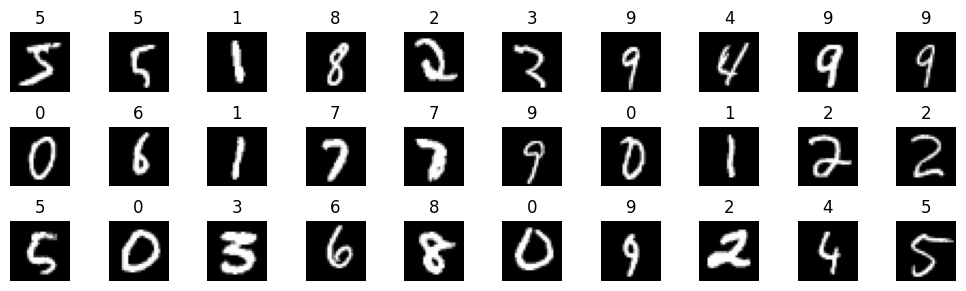

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch import nn
from torchvision.transforms import v2
from utils import load_mnist_subset, eval_model, show_samples, visualize_transform, train_model, show_single_image

# Set your desired values
n = 100  # Sample every n-th image
C = 10  # Number of classes to select
selected_classes, train_dataset, test_dataset = load_mnist_subset(C, n)

show_samples(train_dataset)

## Training a Neural Network 

Let's use the existing neural network implementation and train it on the already loaded training and test set.

We will use the predefined method ```train_model``` with the signature

```

train_model(model: nn.Module,
    train_dataset: torch.utils.data.dataset.TensorDataset,
    test_dataset: torch.utils.data.dataset.TensorDataset,
    optimizer: torch.optim.Optimizer,
    random_transform: function =lambda x:x ,
    num_batches: int = 5000
)

```

to train our model. Its parameters are ```model``` a machine learning model, ```train_dataset``` and ```test_dataset```, the training and test datasets, ```optimizer``` a Pytorch optimizer, ```random_transform``` a function that, given a (batch of) images, applies a random transformation to them, and finally ```num_batches```, which is the number of batches to train on during training. 


We first use Adam with a learning rate of 0.001 for all Neural Network training in this assignment.
Train the model using the default parameters. We can see that the NN correctly predicts the entire training set very quickly, but only ~83% of the test set is correctly classified.

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, input_size= 784, hidden_size= 128, num_classes=C, p_dropout=0):        
        """
        Initializes a new instance of the NeuralNet class.

        Parameters:
        - input_size (int): The number of input features. Default is 784 (the amount of pixels in a MNIST image).
        - hidden_size (int): The number of neurons in the hidden layer. Default is 128.
        - num_classes (int): The number of output classes. Default is C (in this Notebook 10).
        - p_dropout (float): The dropout probability applied to the hidden layers. Default is 0 (no dropout).
        """
        super(NeuralNet, self).__init__()
        # Set random seed for reproducibility
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Dropout(p=p_dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.Dropout(p=p_dropout),
        )
   
    def forward(self, x):
        return self.net(x)


model = NeuralNet(p_dropout=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
train_acc, test_acc = train_model(model, train_dataset, test_dataset, optimizer)

Batch [500/5000], Loss: 1.71e-05 Acc. Train: 100.000 Test: 83.250
Batch [1000/5000], Loss: 1.60e-05 Acc. Train: 100.000 Test: 83.400
Batch [1500/5000], Loss: 1.12e-05 Acc. Train: 100.000 Test: 83.530
Batch [2000/5000], Loss: 4.36e-06 Acc. Train: 100.000 Test: 83.570
Batch [2500/5000], Loss: 4.04e-06 Acc. Train: 100.000 Test: 83.650
Batch [3000/5000], Loss: 2.37e-06 Acc. Train: 100.000 Test: 83.680
Batch [3500/5000], Loss: 1.36e-06 Acc. Train: 100.000 Test: 83.700
Batch [4000/5000], Loss: 1.26e-06 Acc. Train: 100.000 Test: 83.650
Batch [4500/5000], Loss: 1.18e-06 Acc. Train: 100.000 Test: 83.750
Batch [5000/5000], Loss: 6.90e-07 Acc. Train: 100.000 Test: 83.760
Accuracy of the network on the 10000 test images: 83.76 %


## Adversarial Attack [40 points]

Your first task is to implement an adversarial attack. 
The idea of an adversarial attack is simple: rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack adjusts the input data based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to minimize the loss  with respect to the false target label.

We have already provided you with a code-skeleton for the adversarial attack, which also visualizes the perturbation.
The function adversarial_attack has the following signature:
```
    adversarial_attack(
        original_sample: torch.Tensor with shape (1,28,28),
        model:  nn.Module the neural network,
        target: int the false label, we want our model to classify the perturbed image as (defaul 1)
    )
```
Importantly:
- The parameters of the model stay unchanged, we only perturb the image
- The loss you should minimize is the CrossEntropyLoss
- Use SGD with learning rate 1
- If the attack has not worked after 50000 steps, terminate the attack

*Tips:*
- *You can tell pytorch that it should record operations on a tensor with ```requires_grad_```*
- *You can use very similar code as when training a model, but you don't optimize the model parameters, but rather the preturbed image*

In [ ]:
single_img = test_dataset[2][0]


def adversarial_attack(original, model, target=1):


    perturbed = original.clone()

    #Your Code here
    
    # Visualization
    fig, ax = plt.subplots(1, 3)
    show_single_image(original, ax[0])
    ax[0].set_title('Original')
    show_single_image(perturbed, ax[1])
    ax[1].set_title('Perturbed')
    show_single_image(perturbed - original, ax[2])
    ax[2].set_title(f'Perturbation L2: {torch.norm(perturbed - original):.1f}')
    return perturbed

Apply the adversarial attack to the trained model. 
You can see the original image, the pertubed image as well as the perturbation.
You should see a L2-norm of the perturbation of around 60, this indicates, that the attack had to apply a perturbation with l2-norm 60 to yield a succesful attack. 
This distance is an indication for the regularization of the model.

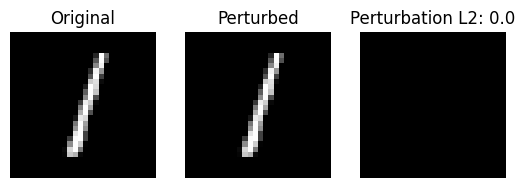

In [14]:
_ = adversarial_attack(single_img, model, target=8)

## Option 1: L2 regularization on the weights [15 points]
Now let's implement l2 regularization (a.k.a. weight-decay) on the weights.
Try out the different regularization strength (0.01, 10.) and visualize the training dynamics.
Can you see an improvement in the test accuracy?

Apply an adversarial attack to the model with the best regularization

## Option 2: Data Augmentation [25 points]
Another option of regularizing the model is by doing data augmentation. By randomly modifying the samples we artifically create a bigger dataset. 
We will use the already implemented transformations from ```torchvision.transforms.v2```
Implement the following transformations with parameters:
- Random Affine Transformation (Rotation from -15 to 15 degrees, translation by 10% in horizontal and vertical direction, scaling from 80% to 110% percent)
- Elastic Transformer (magnitude 20 and smoothness 6)
- Random Application of both, with 90% chance of applying each one 

In [21]:
# Your Code here
# This is a placeholder
random_transform = lambda x: x.transpose(-1,-2)

Use the function ```visualize_transform(train_dataset, transform=random_transform)``` for visualizing the transformed images

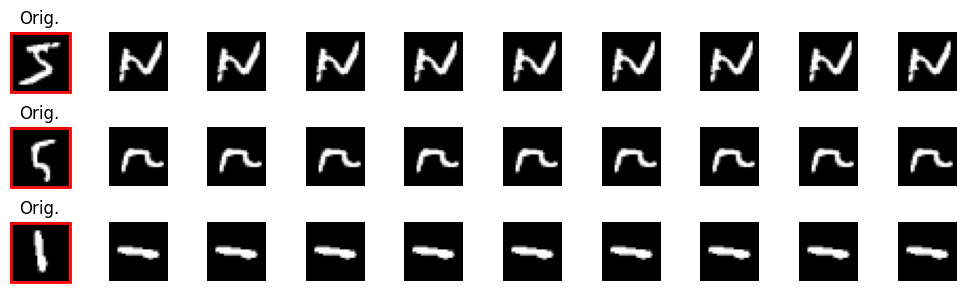

In [22]:
visualize_transform(train_dataset, transform=random_transform)

Train a Neural Network using the random transformations (and no weight decay etc) and visualize the training curves 

In [ ]:
model = NeuralNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=l)  
train_acc, test_acc = train_model(model, train_dataset, test_dataset, optimizer, random_transform=random_transform)

In [ ]:
_ = adversarial_attack(single_img, model, target=8)

## Option 3: Dropout [15 points]
Now let's try out dropout. It is already implemented and try out different dropout rates (0.001, 0.01, 0.1) (and no weight decay or data augmentation) and visualize training.
Again apply an adversarial attack to the best performing network.
What can you see?

*General tip: With dropout, you only want to apply dropout during **training**. In Pytorch you can tell the model, whether it is in the training or eval phase  with ```model.train()``` and ```model.eval()```*

In [ ]:
_ = adversarial_attack(single_img, dropout_models[0.01], target=8)

## Observations [5 points]
- What effects did you see when applying the different regularization techniques?